In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from io import StringIO
import glob
import os
import raytracing as rt
from scipy.ndimage import gaussian_filter
from scipy.stats import linregress

import scipy.optimize as spo
import scipy.constants as spc
import scipy.integrate as spi
import scipy.linalg as spl
import scipy.signal as spsi
import scipy.stats as spst

# Données de la partie 1

In [7]:
def lire_csv(chemin_fichier):
    """
    Lecture d'un fichier CSV avec une première ligne à ignorer,
    et renvoie un DataFrame pandas.

    Args:
        chemin_fichier (str): Le chemin d'accès vers le fichier CSV.

    Returns:
        pandas.DataFrame: Un DataFrame pandas contenant les données du fichier CSV.
    """
    # Lire le fichier en ignorant la première ligne
    with open(chemin_fichier, 'r', encoding='utf-8') as fichier:
        lignes = fichier.readlines()[1:]  # Ignorer la première ligne
    
    # Préparer le contenu transformé
    contenu_transforme = []
    for ligne in lignes:
        partie_gauche, _, partie_droite = ligne.partition(', ')  # Séparer à la première virgule
        partie_gauche, partie_droite = partie_gauche.replace(',', '.'), partie_droite.replace(',', '.')   # Au cas où, mais devrait être inutile ici
        ligne_transformee = partie_gauche + ';' + partie_droite
        contenu_transforme.append(ligne_transformee)
    
    # Convertir le contenu transformé en un objet StringIO
    contenu_csv = StringIO(''.join(contenu_transforme))
    
    # Lire le contenu transformé en DataFrame
    df = pd.read_csv(contenu_csv, names=['Pixels', 'Value'],sep=";")
    return df

In [8]:
df_partie_1 = pd.read_excel("Projet_final.xlsx", sheet_name="Partie 1")

volume = df_partie_1[r"Volume solution ajoutée (ml)"]
#mu_2d = df_partie_1[r"2D \mu"]
mu_3d = df_partie_1[r"3D \mu"]
sigma_3d = df_partie_1[r"3D \sigma"]
ln_intensity = df_partie_1[r"2D ln(I_0/I)"]
sigma_ln_intensity = df_partie_1[r"2D \sigma \ln(I_0/I)"]

In [9]:
# Propagation des incertitudes en 2d
diametre_cylindre = 7
incertitude_cylindre = 0.1

def propagation_incertitudes_division_liste(mesures, incertitudes, diviseur, incertitude_diviseur):
    resultats = []
    incertitudes_resultats = []
    for mesure, incertitude in zip(mesures, incertitudes):
        resultat = mesure / diviseur
        incertitude_resultat = resultat * np.sqrt((incertitude / mesure)**2 + (incertitude_diviseur / diviseur)**2)
        resultats.append(resultat)
        incertitudes_resultats.append(incertitude_resultat)
    return resultats, incertitudes_resultats

mu_2d, sigma_2d = propagation_incertitudes_division_liste(ln_intensity, sigma_ln_intensity, diametre_cylindre, incertitude_cylindre)

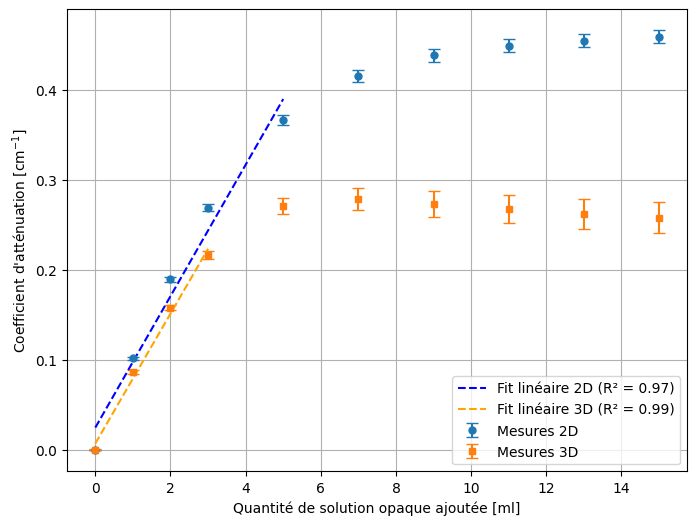

In [14]:
plt.figure(figsize=(8, 6))

plt.errorbar(volume, mu_2d, yerr=sigma_2d, fmt='o', capsize=4, markersize=5, linestyle='', label='Mesures 2D')
plt.errorbar(volume, mu_3d, yerr=sigma_3d, fmt='s', capsize=4, markersize=5, linestyle='', label='Mesures 3D')

x_2d = np.array(volume[:5])
y_2d = np.array(mu_2d[:5])
slope_2d, intercept_2d, r_value_2d, _, _ = linregress(x_2d, y_2d)
r_squared_2d = r_value_2d ** 2
plt.plot(x_2d, slope_2d * x_2d + intercept_2d, color='blue', linestyle='--', label=f'Fit linéaire 2D (R² = {r_squared_2d:.2f})')

x_3d = np.array(volume[:4])
y_3d = np.array(mu_3d[:4])
slope_3d, intercept_3d, r_value_3d, _, _ = linregress(x_3d, y_3d)
r_squared_3d = r_value_3d ** 2
plt.plot(x_3d, slope_3d * x_3d + intercept_3d, color='orange', linestyle='--', label=f'Fit linéaire 3D (R² = {r_squared_3d:.2f})')

plt.xlabel('Quantité de solution opaque ajoutée [ml]')
plt.ylabel("Coefficient d'atténuation [cm$^{-1}$]")
plt.legend()
plt.grid(True)


plt.show()